In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import tab10
from matplotlib.patches import Patch
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import seaborn as sns
import pickle
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from statannotations.Annotator import Annotator
from anndata import read_h5ad
from skimage.filters import unsharp_mask
from skimage.transform import resize_local_mean


from plots import plot_overlay

data_dir = "/mnt/data5/spatial/FMs-for-spatialomics/data"

## Load Data

In [2]:
slides = [
    "CD-A",
    "CD-B",
    "CD-C",
    "CD-D",
    "UC-A",
    "UC-B",
    "UC-C",
    "UC-D",
]

data = []
for slide in slides:
    adata = read_h5ad(os.path.join(data_dir, f"{slide}.h5ad"))
    adata.obsm["X_expr_norm"] = normalize(adata.obsm["X_expr"])
    adata.obsm["X_hist_norm"] = normalize(adata.obsm["X_hist"])
    data.append(adata)

/home/ssong/miniconda3/envs/spatialFM/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ssong/miniconda3/envs/spatialFM/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ssong/miniconda3/envs/spatialFM/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ssong/miniconda3/envs/spatialFM/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ssong/miniconda3/envs/spatialFM/lib/python3.10/site-packages/anndata/_

## Analysis

### Cluster Across Slides

In [3]:
expr = np.concatenate([adata.obsm["X_expr_norm"] for adata in data])
hist = np.concatenate([adata.obsm["X_hist_norm"] for adata in data])

In [4]:
n_clusters = 8
concat = normalize(np.concatenate([expr, hist], axis=1))
kmeans = KMeans(n_clusters=n_clusters, n_init="auto", random_state=42)
all_clusters = kmeans.fit_predict(concat)

In [5]:
# Prepare data for all downstream analyses
offset = 0
counts = dict()
clusters = []
all_representative_tiles = []
for adata, slide in zip(data, slides):
    dz, sec = slide.split("-")
    n = adata.n_obs
    slide_clusters = all_clusters[offset:offset+n]
    slide_concat = concat[offset:offset+n]
    temp = pd.value_counts(slide_clusters)
    counts[(dz, sec)] = temp.sort_index()
    offset += n
    clusters.append(slide_clusters)

    # Also compute representative tiles
    dists = pairwise_distances(
        kmeans.cluster_centers_,
        slide_concat,
        metric="cosine",
    )
    cluster_idxs = dists.argsort(axis=1)[:, 0]
    representative_tiles = adata.obsm["tiles"][cluster_idxs]
    all_representative_tiles.append(representative_tiles)
counts = pd.DataFrame(counts).fillna(0).astype(int)

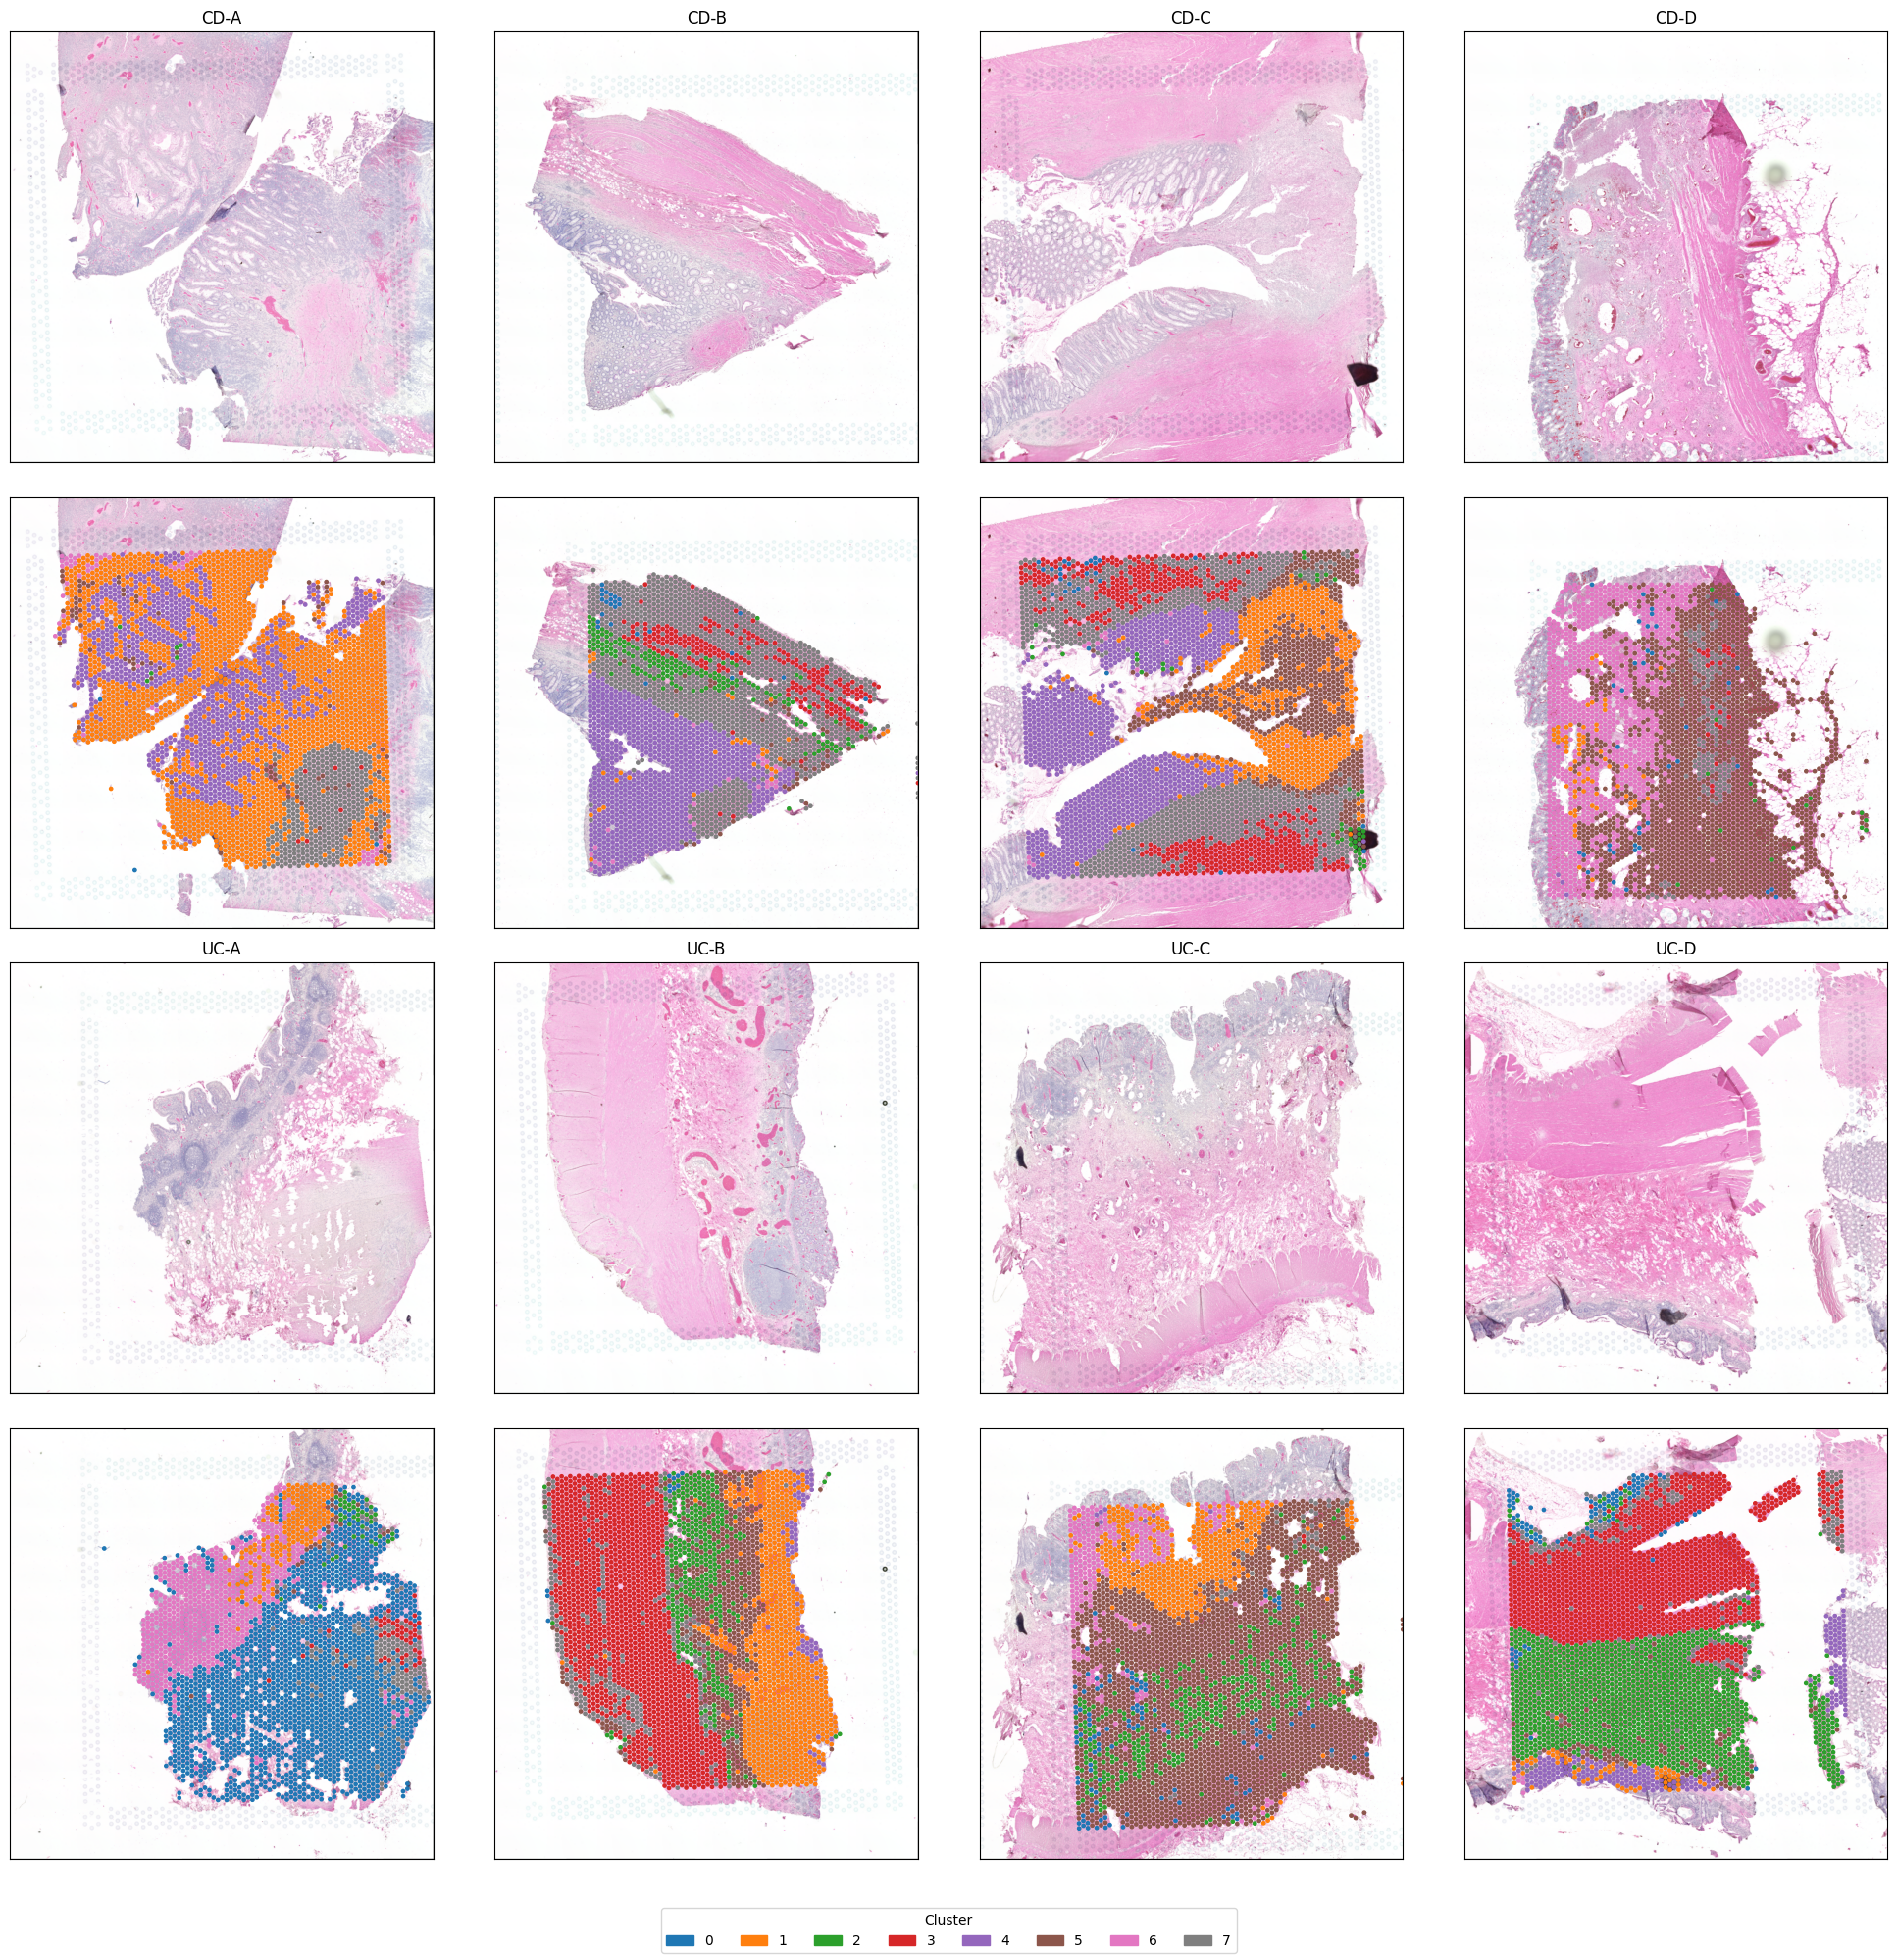

In [6]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for i, (slide, adata, slide_clusters) in enumerate(zip(slides, data, clusters)):
    col = i % 4
    row = i // 4 * 2
    ax = axs[row, col]
    im = adata.uns["spatial"]["slide"]["images"]["hires"]
    ax.imshow(im)
    ax.set_title(slide)
    ax.set_xticks([])
    ax.set_yticks([])

    ax = axs[row + 1, col]
    im = adata.uns["spatial"]["slide"]["images"]["hires"]
    scale_factor = adata.uns["spatial"]["slide"]["scalefactors"]["tissue_hires_scalef"]
    spot_diameter = adata.uns["spatial"]["slide"]["scalefactors"]["spot_diameter_fullres"]
    spot_radius = spot_diameter / 2 * scale_factor
    spot_df = adata.obs.rename(columns={"pxl_col_in_fullres": "x", "pxl_row_in_fullres": "y"})
    spot_df[["x", "y"]] *= scale_factor
    plot_overlay(
        ax=ax,
        cmap=tab10,
        im=im,
        spot_df=spot_df,
        spot_radius=spot_radius,
        spot_values=slide_clusters,
        # title=slide,
    )
    ax.set_xticks([])
    ax.set_yticks([])
elements = [Patch(color=tab10(c), label=str(c)) for c in range(n_clusters)]

fig.tight_layout()
fig.subplots_adjust(bottom=0.05)
fig.legend(handles=elements, loc="lower center", ncol=n_clusters, title="Cluster")

fig.savefig("figs/clusters.png")
fig.savefig("figs/clusters.pdf")

### Compute Per Disease Slide Proportions

In [7]:
def cluster_proportion_quartiles(counts, name, n_clusters, ax=None):
    fracs = counts.div(counts.sum(axis=0), axis=1)

    fracs.index.name = "cluster"
    fracs.columns.names = ["disease", "section"]
    temp = fracs.reset_index()
    temp = temp.melt(id_vars="cluster", value_name="slide proportion")

    ax = sns.boxplot(
        data=temp,
        x="cluster",
        y="slide proportion",
        hue="disease",
        palette="deep",
        # gap=0.1,
        ax=ax,
    )
    ax.set_title(name)

    pairs = [((c, "CD"), (c, "UC")) for c in range(n_clusters)]
    annotator = Annotator(ax, pairs, data=temp, x="cluster", y="slide proportion", hue="disease")
    annotator.configure(test="t-test_ind", text_format="simple", show_test_name=False)
    annotator.apply_and_annotate()

1_CD vs. 1_UC: t-test independent samples, P_val:6.056e-01 t=5.447e-01
0_CD vs. 0_UC: t-test independent samples, P_val:3.191e-01 t=-1.086e+00
2_CD vs. 2_UC: t-test independent samples, P_val:1.658e-01 t=-1.577e+00
3_CD vs. 3_UC: t-test independent samples, P_val:2.524e-01 t=-1.266e+00
4_CD vs. 4_UC: t-test independent samples, P_val:4.257e-02 t=2.566e+00
5_CD vs. 5_UC: t-test independent samples, P_val:9.609e-01 t=-5.116e-02
6_CD vs. 6_UC: t-test independent samples, P_val:9.081e-01 t=1.204e-01
7_CD vs. 7_UC: t-test independent samples, P_val:1.126e-01 t=1.857e+00


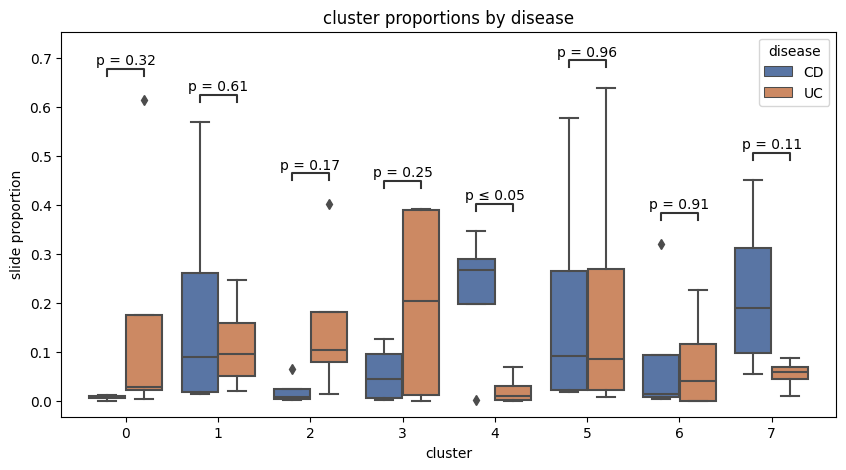

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
cluster_proportion_quartiles(counts, name="cluster proportions by disease", n_clusters=n_clusters, ax=ax)
fig.savefig("figs/proportions.png")
fig.savefig("figs/proportions.pdf")

### Plot Representative Tiles

In [9]:
def plot_representative_tiles(
    all_representative_tiles,
    cluster: int,
    title: str = "",
    sharpen: bool = False,
    radius: int = 5,
    amount: float = 1.0,
):
    fig, axs = plt.subplots(4, 2, figsize=(4, 8))
    for representative_tiles, slide, ax in zip(all_representative_tiles, slides, axs.T.flatten()):
        tile = representative_tiles[cluster]
        if sharpen:
            tile = resize_local_mean(tile, (224, 224))
            tile = unsharp_mask(tile, radius=radius, amount=amount)
        ax.set_title(slide)
        ax.imshow(tile)
        ax.axis("off")
    fig.suptitle(title)
    fig.savefig(f"figs/cluster-{cluster}.png")
    fig.savefig(f"figs/cluster-{cluster}.pdf")

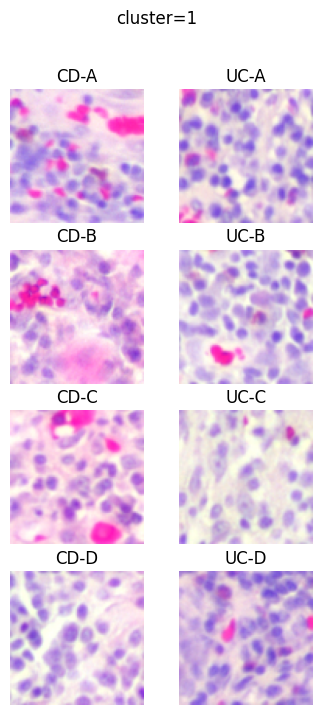

In [10]:
plot_representative_tiles(all_representative_tiles, 1, "cluster=1", sharpen=True)

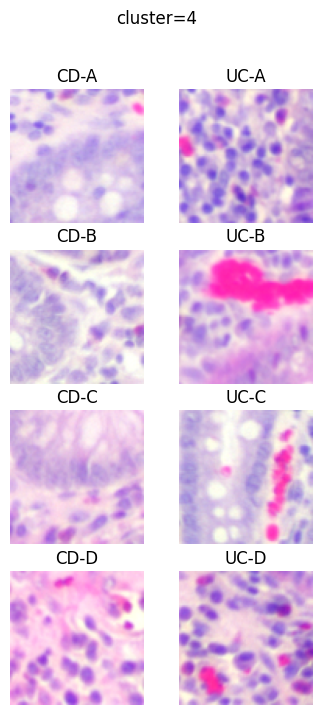

In [11]:
plot_representative_tiles(all_representative_tiles, 4, "cluster=4", sharpen=True)

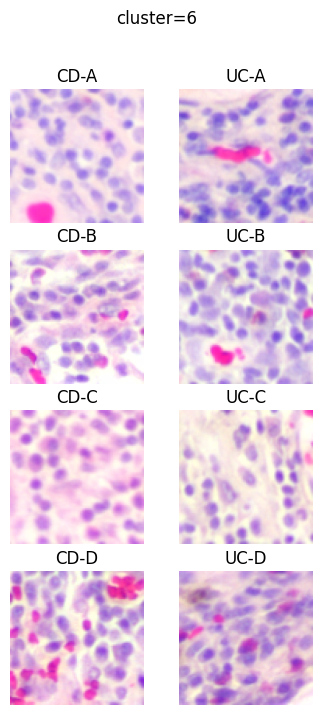

In [12]:
plot_representative_tiles(all_representative_tiles, 6, "cluster=6", sharpen=True)

### Differential Gene Expression

In [13]:
count_dfs = []
meta_dfs = []
for slide, slide_clusters, adata in zip(slides, clusters, data):
    count_df = adata.to_df()
    count_dfs.append(count_df)
    count_df.index = slide + "/" + count_df.index

    meta_df = pd.DataFrame(index=count_df.index)
    meta_df["disease"] = slide.split("-")[0]
    meta_df["slide"] = slide
    meta_df["cluster"] = slide_clusters
    meta_dfs.append(meta_df)

count_df = pd.concat(count_dfs)
meta_df = pd.concat(meta_dfs)

In [14]:
meta_df["target"] = meta_df["cluster"] == 4
mask = meta_df["cluster"].isin([1, 4, 6])
meta_df = meta_df[mask]
count_df = count_df[mask]

In [15]:
genes_to_keep = count_df.columns[(count_df.sum(axis=0) >= 10) & (~count_df.columns.duplicated(keep=False))]
count_df = count_df[genes_to_keep]

any_0s_per_gene = (count_df == 0).any(axis=0)
if any_0s_per_gene.all():
    count_0s_per_gene = (count_df == 0).sum()
    min_val = count_0s_per_gene.min()
    min_idx = count_0s_per_gene.argmin()
    gene = count_df.columns[min_idx]
    print("All genes include 0 counts, this can lead DESeq2 to become intractable.")
    print(f"Excluding {min_val} samples so {gene} will have no 0 counts.")
    mask = count_df[gene] != 0
    count_df = count_df[mask]
    meta_df = meta_df[mask]

assert not (count_df == 0).any(axis=0).all()
assert not count_df.columns.duplicated().any()

All genes include 0 counts, this can lead DESeq2 to become intractable.
Excluding 2 samples so IGKC will have no 0 counts.


In [24]:
len(count_df)

9890

In [16]:
inference = DefaultInference(n_cpus=16)
dds = DeseqDataSet(
    counts=count_df,
    metadata=meta_df,
    design_factors="target",
    refit_cooks=True,
    inference=inference,
    n_cpus=16,
)

In [17]:
dds.deseq2()

with open("dds.pkl", "wb") as f:
    pickle.dump(dds, f)

Fitting size factors...
... done in 7.75 seconds.

Fitting dispersions...
... done in 17.93 seconds.

Fitting dispersion trend curve...
... done in 0.42 seconds.

Fitting MAP dispersions...
... done in 20.34 seconds.

Fitting LFCs...
... done in 37.21 seconds.

Calculating cook's distance...
... done in 35.61 seconds.

Replacing 0 outlier genes.



In [18]:
stat_res = DeseqStats(dds, inference=inference)
stat_res.summary()

with open("stat_results.pkl", "wb") as f:
    pickle.dump(stat_res, f)

Running Wald tests...
... done in 5.21 seconds.



Log2 fold change & Wald test p-value: target True vs False
         baseMean  log2FoldChange     lfcSE      stat        pvalue  \
SAMD11   0.017644       -0.705199  0.411247 -1.714784  8.638481e-02   
NOC2L    0.145185       -0.417153  0.099963 -4.173077  3.005134e-05   
KLHL17   0.023368       -0.748917  0.306691 -2.441924  1.460922e-02   
PLEKHN1  0.018632       -0.739338  0.346714 -2.132414  3.297286e-02   
HES4     0.146993       -0.325731  0.109974 -2.961899  3.057479e-03   
...           ...             ...       ...       ...           ...   
TBL1Y    0.001511       -0.789539  1.646379 -0.479561  6.315394e-01   
USP9Y    0.007896       -0.804931  0.605824 -1.328656  1.839615e-01   
DDX3Y    0.091166       -0.710796  0.108911 -6.526405  6.736712e-11   
TMSB4Y   0.001462       -0.782234  1.303145 -0.600267  5.483286e-01   
KDM5D    0.212779       -0.466918  0.063121 -7.397243  1.390414e-13   

                 padj  
SAMD11   1.012165e-01  
NOC2L    8.539233e-05  
KLHL17   2.04805

In [19]:
with open("dds.pkl", "rb") as f:
    dds = pickle.load(f)
with open("stat_results.pkl", "rb") as f:
    stat_res = pickle.load(f)

In [20]:
stat_res.results_df["pvalue"].clip(lower=np.nextafter(0, 1), inplace=True)

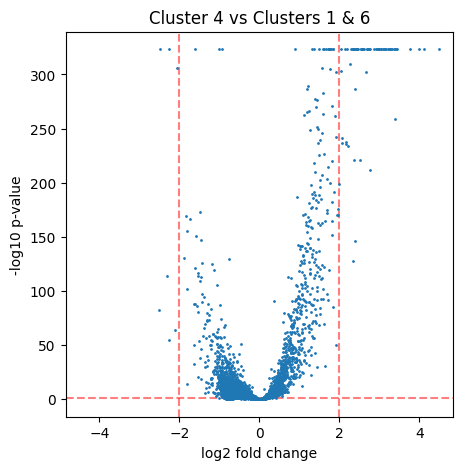

In [21]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_ylabel("-log10 p-value")
ax.set_xlabel("log2 fold change")
ax.scatter(stat_res.results_df["log2FoldChange"], -np.log10(stat_res.results_df["pvalue"]), zorder=3, s=1)
lims = ax.get_xlim()
lim = np.max(np.abs(lims))
ylims = ax.get_ylim()
ax.set_xlim(-lim, lim)
ax.hlines(-np.log10(0.05), -lim, lim, linestyle="--", colors="red", alpha=0.5)
ax.vlines(-2, ylims[0], ylims[1], linestyle="--", colors="red", alpha=0.5)
ax.vlines(2, ylims[0], ylims[1], linestyle="--", colors="red", alpha=0.5)
ax.set_ylim(ylims[0], ylims[1])
ax.set_title("Cluster 4 vs Clusters 1 & 6")
fig.savefig("figs/volcano.png")
fig.savefig("figs/volcano.pdf")

In [22]:
res = stat_res.results_df

In [23]:
res[(res["log2FoldChange"].abs() > 2) & (-np.log10(res["pvalue"]) > -np.log10(0.05))].sort_values("log2FoldChange")

baseMean  log2FoldChange     lfcSE       stat         pvalue  \
CXCL13     0.597288       -2.519697  0.130523 -19.304686   4.905238e-83   
IGHJ6      5.064412       -2.497779  0.056997 -43.822813  4.940656e-324   
CCL19      0.662414       -2.322100  0.102205 -22.719922  2.847134e-114   
HLA-DRB1   0.616723       -2.268160  0.144719 -15.672897   2.317713e-55   
S100A8     2.306005       -2.257208  0.058725 -38.436935  4.940656e-324   
...             ...             ...       ...        ...            ...   
ZG16       1.590057        3.437116  0.075729  45.387087  4.940656e-324   
FABP1      5.063627        3.758335  0.054272  69.250187  4.940656e-324   
LGALS4     6.853953        3.982939  0.045472  87.590452  4.940656e-324   
PIGR      13.438987        4.112317  0.042656  96.406011  4.940656e-324   
PHGR1      8.396238        4.493690  0.053527  83.952016  4.940656e-324   

                   padj  
CXCL13     2.106416e-81  
IGHJ6      0.000000e+00  
CCL19     1.648856e-112  
HLA-DRB1   7.445580e-54  
S100A8     0.000000e+00  
...                 ...  
ZG16       0.000000e+00  
FABP1      0.000000e+00  
LGALS4     0.000000e+00  
PIGR       0.000000e+00  
PHGR1      0.000000e+00  

[74 rows x 6 columns]